# CMS Open Data + Machine Learning
This notebook will take simulated and reconstructed proton-proton collision events from the 2011 CMS Open Data release and build classifiers for differentiating boosted, merged W boson jets from QCD jets.

Author: Javier Duarte, Jean-Roch Vlimant

# Table of Contents
* [References](#References)
* [Loading libraries](#Loading-libraries)
* [Loading numpy arrays](#Loading-numpy-arrays)
* [Convert to Pandas DataFrame](#Convert-to-Pandas-DataFrame)
* [Plotting inputs](#Plotting-inputs)
* [Dense neural network](#Dense-neural-network)
* [Convolutional neural network](#Convolutional-neural-network)
* [LSTM recurrent neural network](#LSTM-recurrent-neural-network)
* [Bidirectional LSTM recurrent neural network](#Bidirectional-LSTM-recurrent-neural-network)



## References
### Datasets
1. CERN CMS Open Data Portal http://opendata.cern.ch/research/CMS?ln=en
1. Simulated dataset TT_weights_CT10_TuneZ2_7TeV-powheg-pythia-tauola in AODSIM format for 2011 collision data. DOI: http://doi.org/10.7483/OPENDATA.CMS.8E2V.PX7B
1. Simulated dataset QCD_Pt-80to120_TuneZ2_7TeV_pythia6 in AODSIM format for 2011 collision data. DOI: http://doi.org/10.7483/OPENDATA.CMS.PUTE.7H2H
1. Simulated dataset QCD_Pt-120to170_TuneZ2_7TeV_pythia6 in AODSIM format for 2011 collision data. DOI: http://doi.org/10.7483/OPENDATA.CMS.QJND.HA88
1. Simulated dataset QCD_Pt-170to300_TuneZ2_7TeV_pythia6 in AODSIM format for 2011 collision data. DOI: http://doi.org/10.7483/OPENDATA.CMS.WKRR.DCJP
1. Simulated dataset QCD_Pt-300to470_TuneZ2_7TeV_pythia6 in AODSIM format for 2011 collision data. DOI: http://doi.org/10.7483/OPENDATA.CMS.X3XQ.USQR
1. Simulated dataset QCD_Pt-470to600_TuneZ2_7TeV_pythia6 in AODSIM format for 2011 collision data. DOI: http://doi.org/10.7483/OPENDATA.CMS.BKTD.SGJX

### Software
1. Github repository for CMSSW package to convert AODSIM to flat numpy array format for Machine Learning. https://github.com/jmduarte/2011-jet-inclusivecrosssection-ntupleproduction-optimized
1. Github repository for manipulating Jet numpy array dataset. https://github.com/jmduarte/scientific-python-hats/tree/master/cms-open-data-ml
1. Keras. https://github.com/fchollet/keras
1. TensorFlow: Large-Scale Machine Learning on Heterogeneous Systems. http://tensorflow.org/
1. Theano: A Python framework for fast computation of mathematical expressions. https://arxiv.org/abs/1605.02688 http://deeplearning.net/software/theano/
1. scikit-learn: Machine Learning in python. http://scikit-learn.org/stable/

### Literature
1. Jet-Images:
Computer Vision Inspired Techniques for Jet Tagging https://arxiv.org/abs/1407.5675
1. Jet-Images -- Deep Learning Edition https://arxiv.org/abs/1511.05190
1. Jet Constituents for Deep Neural Network Based Top Quark Tagging https://arxiv.org/abs/1704.02124
1. QCD-Aware Recursive Neural Networks for Jet Physics https://arxiv.org/abs/1702.00748 
1. Learning Particle Physics by Example: Location-Aware Generative Adversarial Networks for Physics Synthesis https://arxiv.org/abs/1701.05927

## Loading libraries
First we load the relevant libraries.

In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from keras.models import Sequential, Model
from keras.optimizers import SGD
from keras.layers import Input, Activation, Dense, Convolution2D, MaxPooling2D, Dropout, Flatten
from keras.utils import np_utils
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
import sys
import glob
import matplotlib.pyplot as plt
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

## Loading numpy arrays
Now we load two different numpy outputs. One corresponding to a sample of boosted, merged W->qq jets reconstructed from ttbar+jets simulation and several other samples corresponding to QCD jets with different `pthat` ranges.

In [2]:
!mkdir -p output_QCD120
!mkdir -p output_QCD170
!mkdir -p output_QCD300
!mkdir -p output_QCD470
!mkdir -p output_TT

# for downloading from CMS LPC
# QCD
!xrdcp root://cmseos.fnal.gov//eos/uscms/store/user/woodson/DSHEP2017v3/CMS_MonteCarlo2011_Summer11LegDR_QCD_Pt-120to170_TuneZ2_7TeV_pythia6_AODSIM_PU_S13_START53_LV6-v1_00000_file_index/params0.npy_job0_file0.npy output_QCD120/
!xrdcp root://cmseos.fnal.gov//eos/uscms/store/user/woodson/DSHEP2017v3/CMS_MonteCarlo2011_Summer11LegDR_QCD_Pt-170to300_TuneZ2_7TeV_pythia6_AODSIM_PU_S13_START53_LV6-v1_00000_file_index/params0.npy_job0_file0.npy output_QCD170/
!xrdcp root://cmseos.fnal.gov//eos/uscms/store/user/woodson/DSHEP2017v3/CMS_MonteCarlo2011_Summer11LegDR_QCD_Pt-300to470_TuneZ2_7TeV_pythia6_AODSIM_PU_S13_START53_LV6-v1_00000_file_index/params0.npy_job0_file0.npy output_QCD300/
!xrdcp root://cmseos.fnal.gov//eos/uscms/store/user/woodson/DSHEP2017v3/CMS_MonteCarlo2011_Summer11LegDR_QCD_Pt-470to600_TuneZ2_7TeV_pythia6_AODSIM_PU_S13_START53_LV6-v1_00000_file_index/params0.npy_job0_file0.npy output_QCD470/
# TT
!xrdcp root://cmseos.fnal.gov//eos/uscms/store/user/woodson/DSHEP2017v3/CMS_MonteCarlo2011_Summer11LegDR_TT_weights_CT10_TuneZ2_7TeV-powheg-pythia-tauola_AODSIM_PU_S13_START53_LV6-v2_00000_file_index/params0.npy_job50_file0.npy output_TT/
!xrdcp root://cmseos.fnal.gov//eos/uscms/store/user/woodson/DSHEP2017v3/CMS_MonteCarlo2011_Summer11LegDR_TT_weights_CT10_TuneZ2_7TeV-powheg-pythia-tauola_AODSIM_PU_S13_START53_LV6-v2_00000_file_index/params0.npy_job51_file0.npy output_TT/
!xrdcp root://cmseos.fnal.gov//eos/uscms/store/user/woodson/DSHEP2017v3/CMS_MonteCarlo2011_Summer11LegDR_TT_weights_CT10_TuneZ2_7TeV-powheg-pythia-tauola_AODSIM_PU_S13_START53_LV6-v2_00000_file_index/params0.npy_job52_file0.npy output_TT/
!xrdcp root://cmseos.fnal.gov//eos/uscms/store/user/woodson/DSHEP2017v3/CMS_MonteCarlo2011_Summer11LegDR_TT_weights_CT10_TuneZ2_7TeV-powheg-pythia-tauola_AODSIM_PU_S13_START53_LV6-v2_00000_file_index/params0.npy_job53_file0.npy output_TT/
!xrdcp root://cmseos.fnal.gov//eos/uscms/store/user/woodson/DSHEP2017v3/CMS_MonteCarlo2011_Summer11LegDR_TT_weights_CT10_TuneZ2_7TeV-powheg-pythia-tauola_AODSIM_PU_S13_START53_LV6-v2_00000_file_index/params0.npy_job54_file0.npy output_TT/
!xrdcp root://cmseos.fnal.gov//eos/uscms/store/user/woodson/DSHEP2017v3/CMS_MonteCarlo2011_Summer11LegDR_TT_weights_CT10_TuneZ2_7TeV-powheg-pythia-tauola_AODSIM_PU_S13_START53_LV6-v2_00000_file_index/params0.npy_job55_file0.npy output_TT/
!xrdcp root://cmseos.fnal.gov//eos/uscms/store/user/woodson/DSHEP2017v3/CMS_MonteCarlo2011_Summer11LegDR_TT_weights_CT10_TuneZ2_7TeV-powheg-pythia-tauola_AODSIM_PU_S13_START53_LV6-v2_00000_file_index/params0.npy_job56_file0.npy output_TT/
!xrdcp root://cmseos.fnal.gov//eos/uscms/store/user/woodson/DSHEP2017v3/CMS_MonteCarlo2011_Summer11LegDR_TT_weights_CT10_TuneZ2_7TeV-powheg-pythia-tauola_AODSIM_PU_S13_START53_LV6-v2_00000_file_index/params0.npy_job57_file0.npy output_TT/
!xrdcp root://cmseos.fnal.gov//eos/uscms/store/user/woodson/DSHEP2017v3/CMS_MonteCarlo2011_Summer11LegDR_TT_weights_CT10_TuneZ2_7TeV-powheg-pythia-tauola_AODSIM_PU_S13_START53_LV6-v2_00000_file_index/params0.npy_job58_file0.npy output_TT/
!xrdcp root://cmseos.fnal.gov//eos/uscms/store/user/woodson/DSHEP2017v3/CMS_MonteCarlo2011_Summer11LegDR_TT_weights_CT10_TuneZ2_7TeV-powheg-pythia-tauola_AODSIM_PU_S13_START53_LV6-v2_00000_file_index/params0.npy_job59_file0.npy output_TT/
!xrdcp root://cmseos.fnal.gov//eos/uscms/store/user/woodson/DSHEP2017v3/CMS_MonteCarlo2011_Summer11LegDR_TT_weights_CT10_TuneZ2_7TeV-powheg-pythia-tauola_AODSIM_PU_S13_START53_LV6-v2_00000_file_index/params0.npy_job5_file0.npy output_TT/ 
!xrdcp root://cmseos.fnal.gov//eos/uscms/store/user/woodson/DSHEP2017v3/CMS_MonteCarlo2011_Summer11LegDR_TT_weights_CT10_TuneZ2_7TeV-powheg-pythia-tauola_AODSIM_PU_S13_START53_LV6-v2_00000_file_index/params0.npy_job60_file0.npy output_TT/
!xrdcp root://cmseos.fnal.gov//eos/uscms/store/user/woodson/DSHEP2017v3/CMS_MonteCarlo2011_Summer11LegDR_TT_weights_CT10_TuneZ2_7TeV-powheg-pythia-tauola_AODSIM_PU_S13_START53_LV6-v2_00000_file_index/params0.npy_job61_file0.npy output_TT/
!xrdcp root://cmseos.fnal.gov//eos/uscms/store/user/woodson/DSHEP2017v3/CMS_MonteCarlo2011_Summer11LegDR_TT_weights_CT10_TuneZ2_7TeV-powheg-pythia-tauola_AODSIM_PU_S13_START53_LV6-v2_00000_file_index/params0.npy_job62_file0.npy output_TT/
!xrdcp root://cmseos.fnal.gov//eos/uscms/store/user/woodson/DSHEP2017v3/CMS_MonteCarlo2011_Summer11LegDR_TT_weights_CT10_TuneZ2_7TeV-powheg-pythia-tauola_AODSIM_PU_S13_START53_LV6-v2_00000_file_index/params0.npy_job63_file0.npy output_TT/
!xrdcp root://cmseos.fnal.gov//eos/uscms/store/user/woodson/DSHEP2017v3/CMS_MonteCarlo2011_Summer11LegDR_TT_weights_CT10_TuneZ2_7TeV-powheg-pythia-tauola_AODSIM_PU_S13_START53_LV6-v2_00000_file_index/params0.npy_job64_file0.npy output_TT/
!xrdcp root://cmseos.fnal.gov//eos/uscms/store/user/woodson/DSHEP2017v3/CMS_MonteCarlo2011_Summer11LegDR_TT_weights_CT10_TuneZ2_7TeV-powheg-pythia-tauola_AODSIM_PU_S13_START53_LV6-v2_00000_file_index/params0.npy_job65_file0.npy output_TT/
!xrdcp root://cmseos.fnal.gov//eos/uscms/store/user/woodson/DSHEP2017v3/CMS_MonteCarlo2011_Summer11LegDR_TT_weights_CT10_TuneZ2_7TeV-powheg-pythia-tauola_AODSIM_PU_S13_START53_LV6-v2_00000_file_index/params0.npy_job66_file0.npy output_TT/
!xrdcp root://cmseos.fnal.gov//eos/uscms/store/user/woodson/DSHEP2017v3/CMS_MonteCarlo2011_Summer11LegDR_TT_weights_CT10_TuneZ2_7TeV-powheg-pythia-tauola_AODSIM_PU_S13_START53_LV6-v2_00000_file_index/params0.npy_job67_file0.npy output_TT/
!xrdcp root://cmseos.fnal.gov//eos/uscms/store/user/woodson/DSHEP2017v3/CMS_MonteCarlo2011_Summer11LegDR_TT_weights_CT10_TuneZ2_7TeV-powheg-pythia-tauola_AODSIM_PU_S13_START53_LV6-v2_00000_file_index/params0.npy_job68_file0.npy output_TT/
!xrdcp root://cmseos.fnal.gov//eos/uscms/store/user/woodson/DSHEP2017v3/CMS_MonteCarlo2011_Summer11LegDR_TT_weights_CT10_TuneZ2_7TeV-powheg-pythia-tauola_AODSIM_PU_S13_START53_LV6-v2_00000_file_index/params0.npy_job69_file0.npy output_TT/
!xrdcp root://cmseos.fnal.gov//eos/uscms/store/user/woodson/DSHEP2017v3/CMS_MonteCarlo2011_Summer11LegDR_TT_weights_CT10_TuneZ2_7TeV-powheg-pythia-tauola_AODSIM_PU_S13_START53_LV6-v2_00000_file_index/params0.npy_job6_file0.npy output_TT/

[295.5MB/295.5MB][100%][==================================================][49.25MB/s]  
[357.2MB/357.2MB][100%][==================================================][51.02MB/s]  
[432.5MB/432.5MB][100%][==================================================][48.05MB/s]  
[477.4MB/477.4MB][100%][==================================================][47.74MB/s]  
[87.25MB/87.25MB][100%][==================================================][43.62MB/s]  
[158.2MB/158.2MB][100%][==================================================][52.73MB/s]  
[152.9MB/152.9MB][100%][==================================================][50.97MB/s]  
[136.7MB/136.7MB][100%][==================================================][45.58MB/s]  
[139.7MB/139.7MB][100%][==================================================][46.58MB/s]  
[142.4MB/142.4MB][100%][==================================================][47.47MB/s]  
[156.6MB/156.6MB][100%][==================================================][52.18MB/s]  
[87.99MB/87.99MB][100

In [3]:
# get input numpy arrays
inputs = {}
inputs['TT'] = glob.glob('output_TT/*job*.npy')
inputs['QCD120'] = glob.glob('output_QCD120/*job*.npy')
inputs['QCD170'] = glob.glob('output_QCD170/*job*.npy')
inputs['QCD300'] = glob.glob('output_QCD300/*job*.npy')
inputs['QCD470'] = glob.glob('output_QCD470/*job*.npy')

import random
fraction_file = 0.3
max_file = 1

list_params = {}
params = {}
for key, input_files in inputs.iteritems():
    list_params[key] = []
    print key,len(input_files),"files"
    last_file = int(len(input_files)*fraction_file)+1 if fraction_file>0 else -1
    last_file = min(max_file, len(input_files)) if max_file else last_file
    if key=='TT': last_file*=20
    print "Getting",last_file,"/",len(input_files),"files"
    for in_file in input_files[:last_file]:
        try:
            print in_file
            arr = np.load(in_file)
            list_params[key].append(arr)
        except ValueError:
            print 'bad file: %s'%in_file
        except IOError:
            print 'bad io',in_file
    params[key] = np.concatenate(list_params[key])

QCD120 1 files
Getting 1 / 1 files
output_QCD120/params0.npy_job0_file0.npy
TT 22 files
Getting 20 / 22 files
output_TT/params0.npy_job50_file0.npy
output_TT/params0.npy_job51_file0.npy
output_TT/params0.npy_job52_file0.npy
output_TT/params0.npy_job53_file0.npy
output_TT/params0.npy_job54_file0.npy
output_TT/params0.npy_job55_file0.npy
output_TT/params0.npy_job56_file0.npy
output_TT/params0.npy_job57_file0.npy
output_TT/params0.npy_job58_file0.npy
output_TT/params0.npy_job59_file0.npy
output_TT/params0.npy_job5_file0.npy
output_TT/params0.npy_job60_file0.npy
output_TT/params0.npy_job61_file0.npy
output_TT/params0.npy_job62_file0.npy
output_TT/params0.npy_job63_file0.npy
output_TT/params0.npy_job64_file0.npy
output_TT/params0.npy_job65_file0.npy
output_TT/params0.npy_job66_file0.npy
output_TT/params0.npy_job67_file0.npy
output_TT/params0.npy_job68_file0.npy
QCD470 1 files
Getting 1 / 1 files
output_QCD470/params0.npy_job0_file0.npy
QCD170 1 files
Getting 1 / 1 files
output_QCD170/params

## Convert to Pandas DataFrame
Now we can convert the numpy arrays to data frames. First we can look at the features that are available. We can see that we have event-level information (`run`, `lumi`, `event`, `njet_ak7`, `pthat`, `mcweight`), jet-level information (`jet_pt_ak7`, `jet_eta_ak7`, `jet_phi_ak7`, `jet_E_ak7`, `jet_msd_ak7`, `jet_area_ak7`, `jet_jes_ak7`, `jet_tau21_ak7`, `jet_isW_ak7`, `genjet_pt_ak7`, `genjet_eta_ak7`, `genjet_phi_ak7`, `genjet_E_ak7`), and finally PF-candidate-level information (`ak7pfcand_pt`, `ak7pfcand_eta`, `ak7pfcand_phi`, `ak7pfcand_id`, `ak7pfcand_charge`, `ak7pfcand_ijet`). 

To start with, we'll just take the most relevant jet-level information as inputs (`jet_pt_ak7`, `jet_tau21_ak7`, `jet_msd_ak7`, `jet_ncand_ak7`) to try to predict whether the jet is a real boosted, merged W boson, which is given by the boolean `jet_isW_ak7` (The generator-level matching criteria is that a generated W boson which decays to qq is within the jet cone of 0.7 and the deltaR between the daughters is less than 0.7).

In [3]:
# convert to pandas dataframe
df_dict = {}

pt_min = 200
pt_max = 500

print params['TT'].dtype.names

df_dict['TT'] = pd.DataFrame(params['TT'],columns=['jet_pt_ak7','jet_tau21_ak7','jet_msd_ak7','jet_ncand_ak7','jet_isW_ak7', 'pthat','mcweight'])
for QCDbin in ['QCD120','QCD170','QCD300','QCD470']:
    df_dict[QCDbin] = pd.DataFrame(params[QCDbin],columns=['jet_pt_ak7','jet_tau21_ak7','jet_msd_ak7','jet_ncand_ak7','jet_isW_ak7', 'pthat','mcweight'])


df_dict['TT'] = df_dict['TT'].drop_duplicates()
df_dict['TT'] =  df_dict['TT'][(df_dict['TT'].jet_pt_ak7 > pt_min) & (df_dict['TT'].jet_pt_ak7 < pt_max) &  (df_dict['TT'].jet_isW_ak7==1)]

print 'number of W jets: %i'%len(df_dict['TT'])

for QCDbin in ['QCD120','QCD170','QCD300','QCD470']:
    df_dict[QCDbin] = df_dict[QCDbin].drop_duplicates()
    df_dict[QCDbin] =  df_dict[QCDbin][(df_dict[QCDbin].jet_pt_ak7 > pt_min) & (df_dict[QCDbin].jet_pt_ak7 < pt_max) & (df_dict[QCDbin].jet_isW_ak7==0)]
    # take every 20th jet just to make the training faster and have a sample roughly the size of W jets
    df_dict[QCDbin] = df_dict[QCDbin].iloc[::20, :]
    
for QCDbin in ['QCD120','QCD170','QCD300','QCD470']:
    print 'number of QCD jets in bin %s: %i'%( QCDbin, len(df_dict[QCDbin]))

    
df_dict['QCD'] = pd.concat([df_dict['QCD120'],df_dict['QCD170'],df_dict['QCD300'],df_dict['QCD470']])
df = pd.concat([df_dict['TT'],df_dict['QCD']])

#print df_dict['TT'].iloc[:3]
#print df_dict['QCD'].iloc[:3]

('run', 'lumi', 'event', 'met', 'sumet', 'rho', 'pthat', 'mcweight', 'njet_ak7', 'jet_pt_ak7', 'jet_ptraw_ak7', 'jet_eta_ak7', 'jet_phi_ak7', 'jet_E_ak7', 'jet_Eraw_ak7', 'jet_msd_ak7', 'jet_area_ak7', 'jet_jes_ak7', 'jet_tau21_ak7', 'jet_isW_ak7', 'jet_ncand_ak7', 'genjet_pt_ak7', 'genjet_eta_ak7', 'genjet_phi_ak7', 'genjet_E_ak7', 'ak7pfcand_pt', 'ak7pfcand_eta', 'ak7pfcand_phi', 'ak7pfcand_id', 'ak7pfcand_charge', 'ak7pfcand_ijet')
number of W jets: 1722
number of QCD jets in bin QCD120: 37
number of QCD jets in bin QCD170: 690
number of QCD jets in bin QCD300: 1649
number of QCD jets in bin QCD470: 929


## Plotting inputs
Let's make some plots of the inputs for both W and QCD jets, specifically the soft-drop mass `jet_msd_ak7` and the n-subjettiness substructure variable `jet_tau21_ak7`. We can also plot the individual QCD `pthat` bins (weighted by the cross section stored in `mcweight`).

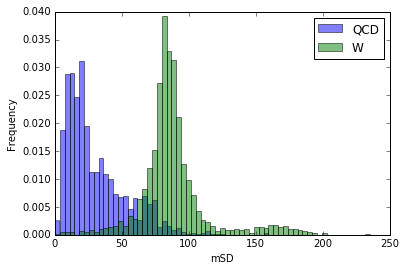

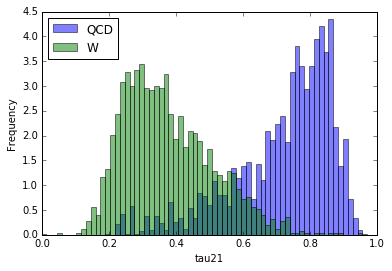

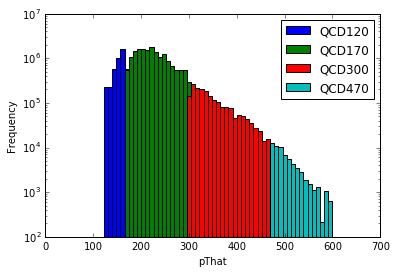

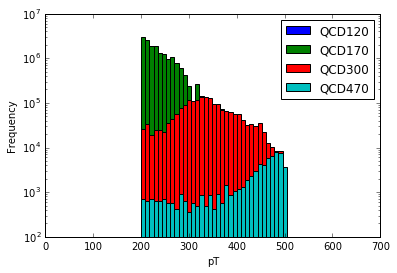

In [4]:
%matplotlib inline
plt.figure()
plt.xlabel('mSD')
bins = np.linspace(0, 250, 70)
df_dict['QCD']['jet_msd_ak7'].plot.hist(bins, alpha=0.5, label='QCD', weights=df_dict['QCD']['mcweight'],normed=True)
df_dict['TT']['jet_msd_ak7'].plot.hist(bins, alpha=0.5, label='W',normed=True)
plt.legend(loc='upper right')
plt.figure()
plt.xlabel('tau21')
bins = np.linspace(0, 1, 70)
df_dict['QCD']['jet_tau21_ak7'].plot.hist(bins, alpha=0.5, label='QCD',weights=df_dict['QCD']['mcweight'],normed=True)
df_dict['TT']['jet_tau21_ak7'].plot.hist(bins, alpha=0.5, label='W',normed=True)
plt.legend(loc='upper left')
plt.figure()
plt.xlabel('pThat')
bins = np.linspace(0, 600, 70)
for QCDbin in ['QCD120','QCD170','QCD300','QCD470']:
    df_dict[QCDbin]['pthat'].plot.hist(bins, alpha=1, label=QCDbin, weights=df_dict[QCDbin]['mcweight'], stacked=True, log=True)
plt.legend(loc='upper right')
plt.figure()
plt.xlabel('pT')
bins = np.linspace(0, 600, 70)
for QCDbin in ['QCD120','QCD170','QCD300','QCD470']:
    df_dict[QCDbin]['jet_pt_ak7'].plot.hist(bins, alpha=1, label=QCDbin, weights=df_dict[QCDbin]['mcweight'], stacked=True, log=True)
plt.legend(loc='upper right')

# Dense neural network
## Defining our model (neural net topology)
We'll start with a densely-connected NN layer. Our model will have a single fully connected hidden layer with the same number of neurons as input variables. The weights are initialized using a small Gaussian random number. The Rectifier activation function is used. The output layer contains a single neuron in order to make predictions. It uses the sigmoid activation function in order to produce a probability output in the range of 0 to 1 that can easily and automatically be converted to class values (0 or 1).

Finally, we are using the logarithmic loss function (`binary_crossentropy`) during training, a standard loss function for binary classification problems. The model also uses the efficient Adam optimization algorithm for gradient descent and accuracy metrics will be collected when the model is trained.

In [5]:
# baseline model
NDIM = 4
def create_baseline():
    # This returns a tensor
    inputs = Input(shape=(NDIM,))    
    x = Dense(NDIM, init='normal', activation='relu')(inputs)
    predictions = Dense(1, init='normal', activation='sigmoid')(x)
    # This creates a model that includes
    # the input layer and two dense layers (one output)
    model = Model(input=inputs, output=predictions)
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = create_baseline()
model.summary()
# visalize model
#from keras.utils.visualize_util import plot
#plot(model)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 4)             0                                            
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 4)             20          input_1[0][0]                    
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 1)             5           dense_1[0][0]                    
Total params: 25
Trainable params: 25
Non-trainable params: 0
____________________________________________________________________________________________________


## Dividing the data for cross validation
Now we can evaluate this model using stratified cross validation in the scikit-learn framework.

We will split the data into two parts (one for training and one for testing). We will also define our early stopping criteria to prevent over-fitting.

In [6]:
dataset = df.values
X = dataset[:,0:NDIM].astype(float)
Y = dataset[:,NDIM]
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)

kfold = StratifiedKFold(n_splits=2, shuffle=True,  random_state=seed)
    
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

## Visualize performance with ROC curves
Here, we visualize the performance of our model with a ROC curve for each cross validation sample.

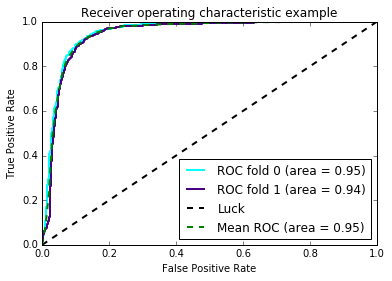

In [17]:
# Run classifier with cross-validation and plot ROC curves
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from scipy import interp

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)

colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange', 'red', 'black', 'green', 'brown'])
lw = 2

i = 0
histories = []
for (train, test), color in zip(kfold.split(X, encoded_Y), colors):
    model = create_baseline()
    history = model.fit(X[train], encoded_Y[train], validation_data=(X[test], encoded_Y[test]), nb_epoch=100, batch_size=32, verbose=0, callbacks=[early_stopping])
    Y_score = model.predict(X[test])
    histories.append(history)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(encoded_Y[test], Y_score)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=lw, color=color, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k', label='Luck')
mean_tpr /= kfold.get_n_splits(X, encoded_Y)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)
plt.xlim([0, 1.0])
plt.ylim([0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## Visualize history of training

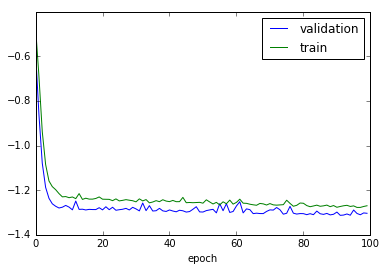

In [18]:
val_loss = np.asarray(histories[0].history['val_loss'])
loss = np.asarray(histories[0].history['loss'])
plt.plot(np.log(val_loss), label='validation')
plt.plot(np.log(loss), label='train')
plt.legend()
plt.xlabel('epoch')

# Convolutional neural network
## Preparing jet images
First we will create a jet-feature-only numpy array as before. This will help us later with being able to select all the PF candidates belonging to single jet.

In [19]:
# now let's prepare some jet images
print params['TT'].dtype.names

df_dict_jet = {}
df_dict_jet['TT'] = pd.DataFrame(params['TT'],columns=['run', 'lumi', 'event', 'met', 'sumet', 'rho', 'pthat', 'mcweight', 'njet_ak7', 'jet_pt_ak7', 'jet_eta_ak7', 'jet_phi_ak7', 'jet_E_ak7', 'jet_msd_ak7', 'jet_area_ak7', 'jet_jes_ak7', 'jet_tau21_ak7', 'jet_isW_ak7', 'jet_ncand_ak7','ak7pfcand_ijet'])
df_dict_jet['TT'] = df_dict_jet['TT'].drop_duplicates()
df_dict_jet['TT'] =  df_dict_jet['TT'][(df_dict_jet['TT'].jet_pt_ak7 > 200) & (df_dict_jet['TT'].jet_pt_ak7 < 500) &  (df_dict_jet['TT'].jet_isW_ak7==1)]

df_dict_cand = {}
df_dict_cand['TT'] = pd.DataFrame(params['TT'],columns=['event', 'jet_pt_ak7', 'jet_isW_ak7', 'ak7pfcand_pt', 'ak7pfcand_eta', 'ak7pfcand_phi', 'ak7pfcand_id', 'ak7pfcand_charge', 'ak7pfcand_ijet'])
df_dict_cand['TT'] =  df_dict_cand['TT'][(df_dict_cand['TT'].jet_pt_ak7 > 200) & (df_dict_cand['TT'].jet_pt_ak7 < 500) &  (df_dict_cand['TT'].jet_isW_ak7==1)]


for QCDbin in ['QCD120','QCD170','QCD300','QCD470']:
    df_dict_jet[QCDbin] = pd.DataFrame(params[QCDbin],columns=['run', 'lumi', 'event', 'met', 'sumet', 'rho', 'pthat', 'mcweight', 'njet_ak7', 'jet_pt_ak7', 'jet_eta_ak7', 'jet_phi_ak7', 'jet_E_ak7', 'jet_msd_ak7', 'jet_area_ak7', 'jet_jes_ak7', 'jet_tau21_ak7', 'jet_isW_ak7', 'jet_ncand_ak7','ak7pfcand_ijet'])
    df_dict_jet[QCDbin] = df_dict_jet[QCDbin].drop_duplicates()
    df_dict_jet[QCDbin] =  df_dict_jet[QCDbin][(df_dict_jet[QCDbin].jet_pt_ak7 > 200) & (df_dict_jet[QCDbin].jet_pt_ak7 < 500) &  (df_dict_jet[QCDbin].jet_isW_ak7==0)]
    # take every 20th jet just to make the training faster and have a sample roughly the size of W jets
    df_dict_jet[QCDbin] = df_dict_jet[QCDbin].iloc[::20, :]
    
    df_dict_cand[QCDbin] = pd.DataFrame(params[QCDbin],columns=['event', 'jet_pt_ak7', 'jet_isW_ak7', 'ak7pfcand_pt', 'ak7pfcand_eta', 'ak7pfcand_phi', 'ak7pfcand_id', 'ak7pfcand_charge', 'ak7pfcand_ijet'])
    df_dict_cand[QCDbin] =  df_dict_cand[QCDbin][(df_dict_cand[QCDbin].jet_pt_ak7 > 200) & (df_dict_cand[QCDbin].jet_pt_ak7 < 500) &  (df_dict_cand[QCDbin].jet_isW_ak7==0)]
    
df_dict_jet['QCD'] = pd.concat([df_dict_jet['QCD120'],df_dict_jet['QCD170'],df_dict_jet['QCD300'],df_dict_jet['QCD470']])
df_dict_cand['QCD'] = pd.concat([df_dict_cand['QCD120'],df_dict_cand['QCD170'],df_dict_cand['QCD300'],df_dict_cand['QCD470']])

print len(df_dict_jet['QCD'])

('run', 'lumi', 'event', 'met', 'sumet', 'rho', 'pthat', 'mcweight', 'njet_ak7', 'jet_pt_ak7', 'jet_ptraw_ak7', 'jet_eta_ak7', 'jet_phi_ak7', 'jet_E_ak7', 'jet_Eraw_ak7', 'jet_msd_ak7', 'jet_area_ak7', 'jet_jes_ak7', 'jet_tau21_ak7', 'jet_isW_ak7', 'jet_ncand_ak7', 'genjet_pt_ak7', 'genjet_eta_ak7', 'genjet_phi_ak7', 'genjet_E_ak7', 'ak7pfcand_pt', 'ak7pfcand_eta', 'ak7pfcand_phi', 'ak7pfcand_id', 'ak7pfcand_charge', 'ak7pfcand_ijet')
3305


# Preprocessing jet images
Here we will define the rotation and reflection we will do to each jet image. 

In [20]:
# rotation + (possible) reflection needed later
def rotate_and_reflect(x,y,w):
    rot_x = []
    rot_y = []
    theta = 0
    maxPt = -1
    for ix, iy, iw in zip(x, y, w):
        dv = np.matrix([[ix],[iy]])-np.matrix([[x.iloc[0]],[y.iloc[0]]])
        dR = np.linalg.norm(dv)
        thisPt = iw
        if dR > 0.35 and thisPt > maxPt:
            maxPt = thisPt
            # rotation in eta-phi plane c.f  https://arxiv.org/abs/1407.5675 and https://arxiv.org/abs/1511.05190:
            # theta = -np.arctan2(iy,ix)-np.radians(90)
            # rotation by lorentz transformation c.f. https://arxiv.org/abs/1704.02124:
            px = iw * np.cos(iy)
            py = iw * np.sin(iy)
            pz = iw * np.sinh(ix)
            theta = np.arctan2(py,pz)+np.radians(90)
            
    c, s = np.cos(theta), np.sin(theta)
    R = np.matrix('{} {}; {} {}'.format(c, -s, s, c))
    for ix, iy, iw in zip(x, y, w):
        # rotation in eta-phi plane:
        #rot = R*np.matrix([[ix],[iy]])
        #rix, riy = rot[0,0], rot[1,0]
        # rotation by lorentz transformation
        px = iw * np.cos(iy)
        py = iw * np.sin(iy)
        pz = iw * np.sinh(ix)
        rot = R*np.matrix([[py],[pz]])
        rix, riy = np.arcsinh(rot[1,0]/iw), np.arcsin(rot[0,0]/iw)
        rot_x.append(rix)
        rot_y.append(riy)
        
    # now reflect if leftSum > rightSum
    leftSum = 0
    rightSum = 0
    for ix, iy, iw in zip(x, y, w):
        if ix > 0: 
            rightSum += iw
        elif ix < 0:
            leftSum += iw
    if leftSum > rightSum:
        ref_x = [-1.*rix for rix in rot_x]
        ref_y = rot_y
    else:
        ref_x = rot_x
        ref_y = rot_y
    
    return np.array(ref_x), np.array(ref_y)


def norm_pt( pt ):
    return (pt-pt_min) / (pt_max - pt_min)

## Visualize average jet image and prepare inputs
We will use histograms to create the jet images (and visualize the averaage jet image after our preprocessing). We will also prepare the 4D tensor inputs needed for training a convolutional neural network.

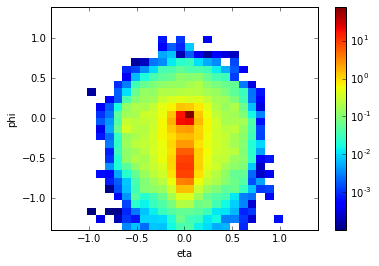

In [26]:
import matplotlib as mpl

nx = 30 # size of image in eta
ny = 30 # size of image in phi
xbins = np.linspace(-1.4,1.4,nx+1)
ybins = np.linspace(-1.4,1.4,ny+1)


jet_images_dict = {}
# 4D tensor (tensorflow backend)
# 1st dim is jet index
# 2nd dim is pt value (or rgb layer, etc.)
# 3rd dim is eta bin
# 4th dim is phi bin
# 4D tensor (theano backend)
# 1st dim is jet index
# 2nd dim is eta bin
# 3rd dim is phi bin
# 4th dim is pt value (or rgb layer, etc.)

def prepareImages(process, df_dict_cand, df_dict_jet):
    list_x = []
    list_y = []
    list_w = []
    if K.image_dim_ordering()=='tf':
        jet_images = np.zeros((len(df_dict_jet[process]), nx, ny, 1))
    else:        
        jet_images = np.zeros((len(df_dict_jet[process]), 1, nx, ny))
    
    for i in range(0,len(df_dict_jet[process])):
        # get the ith jet
        df_dict_cand_i = df_dict_cand[process][(df_dict_cand[process]['ak7pfcand_ijet'] == df_dict_jet[process]['ak7pfcand_ijet'].iloc[i]) & (df_dict_cand[process]['event'] == df_dict_jet[process]['event'].iloc[i]) ]
        # relative eta
        x = df_dict_cand_i['ak7pfcand_eta']-df_dict_cand_i['ak7pfcand_eta'].iloc[0]
        # relative phi
        y = df_dict_cand_i['ak7pfcand_phi']-df_dict_cand_i['ak7pfcand_phi'].iloc[0]
        weights = df_dict_cand_i['ak7pfcand_pt'] # pt of candidate is the weight
        x,y = rotate_and_reflect(x,y,weights)
        list_x.append(x)
        list_y.append(y)
        list_w.append(weights)
        hist, xedges, yedges = np.histogram2d(x, y,weights=weights, bins=(xbins,ybins))
        for ix in range(0,nx):
            for iy in range(0,ny):
                if K.image_dim_ordering()=='tf':
                    jet_images[i,ix,iy,0] = hist[ix,iy]
                else:
                    jet_images[i,0,ix,iy] = hist[ix,iy]
    return jet_images, list_x, list_y, list_w

jet_images_dict['TT'], list_x, list_y, list_w = prepareImages('TT', df_dict_cand, df_dict_jet)

all_x = np.concatenate(list_x)
all_y = np.concatenate(list_y)
all_w = np.concatenate(list_w)
all_w = 1.*all_w/len(jet_images_dict['TT']) # to get average
plt.figure('W') 
plt.hist2d(all_x, all_y, weights=all_w, bins=(xbins,ybins), norm=mpl.colors.LogNorm())
plt.colorbar()
plt.xlabel('eta')
plt.ylabel('phi')
plt.show()

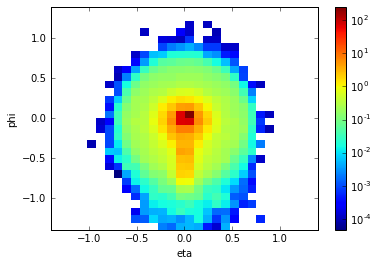

In [27]:
# do the same thing for QCD
jet_images_dict['QCD'], list_x, list_y, list_w = prepareImages('QCD', df_dict_cand, df_dict_jet)

all_x = np.concatenate(list_x)
all_y = np.concatenate(list_y)
all_w = np.concatenate(list_w)
all_w = 1.*all_w/njets # to get average
plt.figure() 
plt.hist2d(all_x, all_y, weights=all_w, bins=(xbins,ybins), norm=mpl.colors.LogNorm())
plt.colorbar()
plt.xlabel('eta')
plt.ylabel('phi')
plt.show()

## Define convolutional model

In [29]:
# Model
def build_conv_model():
    """Test model.  Consists of several convolutional layers followed by dense layers and an output layer"""
    if K.image_dim_ordering()=='tf':
        input_layer = Input(shape=(nx, ny, 1))
    else:
        input_layer = Input(shape=(1, nx, ny))
    layer = Convolution2D(8, 11, 11, border_mode='same')(input_layer)
    layer = Activation('tanh')(layer)
    layer = MaxPooling2D(pool_size=(2,2))(layer)
    layer = Convolution2D(8, 3, 3, border_mode='same')(layer)
    layer = Activation('tanh')(layer)
    layer = MaxPooling2D(pool_size=(3,3))(layer)
    layer = Convolution2D(8, 3, 3, border_mode='same')(layer)
    layer = Activation('tanh')(layer)
    layer = MaxPooling2D(pool_size=(3,3))(layer)
    layer = Flatten()(layer)
    layer = Dropout(0.20)(layer)
    layer = Dense(20)(layer)
    layer = Dropout(0.10)(layer)
    output_layer = Dense(1, activation='sigmoid')(layer)
    model = Model(input=input_layer, output=output_layer)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model
conv_model = build_conv_model()
conv_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_5 (InputLayer)             (None, 1, 30, 30)     0                                            
____________________________________________________________________________________________________
convolution2d_4 (Convolution2D)  (None, 8, 30, 30)     976         input_5[0][0]                    
____________________________________________________________________________________________________
activation_4 (Activation)        (None, 8, 30, 30)     0           convolution2d_4[0][0]            
____________________________________________________________________________________________________
maxpooling2d_4 (MaxPooling2D)    (None, 8, 15, 15)     0           activation_4[0][0]               
___________________________________________________________________________________________

Train on 2513 samples, validate on 2514 samples
Epoch 1/1
2513/2513 [==============================] - 51s - loss: 0.5032 - acc: 0.7589 - val_loss: 0.3109 - val_acc: 0.8946

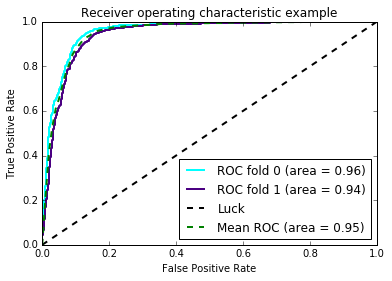

In [32]:
# Run classifier with cross-validation and plot ROC curves
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from scipy import interp

X = np.concatenate([jet_images_dict['TT'], jet_images_dict['QCD']])
Y_TT = np.ones(jet_images_dict['TT'].shape[0])
Y_QCD = np.zeros(jet_images_dict['QCD'].shape[0])
Y = np.concatenate([Y_TT, Y_QCD])

encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)


kfold = StratifiedKFold(n_splits=2, shuffle=True,  random_state=seed)
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
    

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange', 'red', 'black', 'green', 'brown'])
lw = 2

i = 0
histories = []
for (train, test), color in zip(kfold.split(X, encoded_Y), colors):
    conv_model = build_conv_model()
    history = conv_model.fit(X[train], encoded_Y[train], validation_data=(X[test], encoded_Y[test]), nb_epoch=1, batch_size=32, verbose=1, callbacks=[early_stopping])
    Y_score = conv_model.predict(X[test])
    histories.append(history)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(encoded_Y[test], Y_score)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=lw, color=color, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k', label='Luck')
mean_tpr /= kfold.get_n_splits(X, encoded_Y)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)
plt.xlim([0, 1.0])
plt.ylim([0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()
    

## Visualize learned filters

convolution2d_8


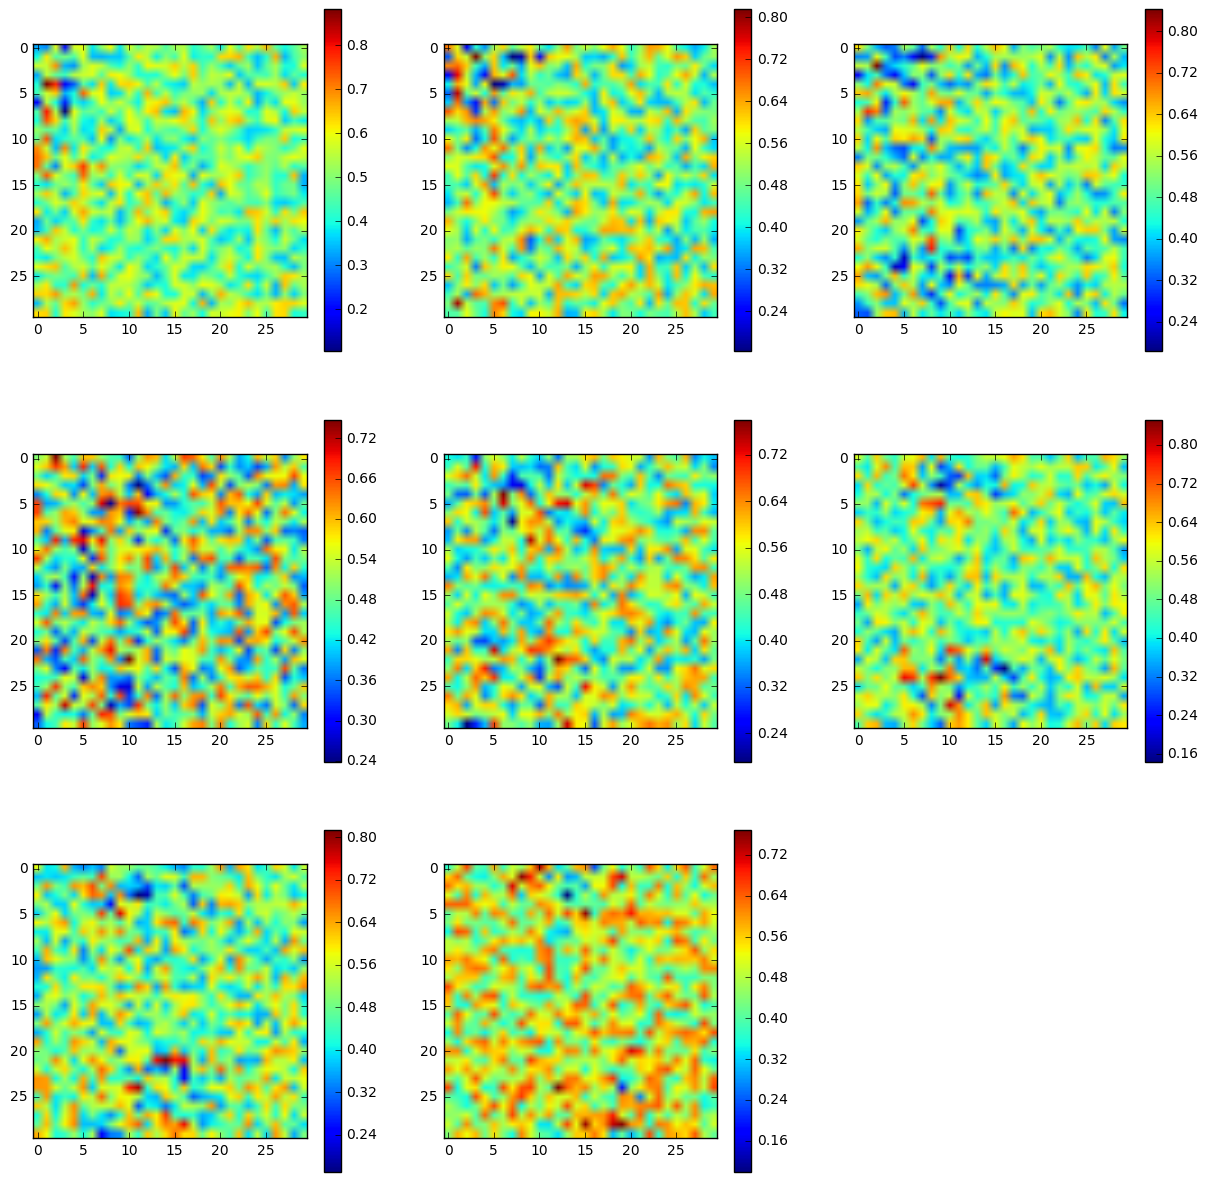

In [13]:
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    #x *= 255
    if K.image_dim_ordering()=='tf':
        x = x.transpose((1, 2, 0))
        x = x.transpose((1, 0, 2))
    #x = np.clip(x, 0, 255).astype('uint8')
    return x

# dimensions of the generated pictures for each filter.
img_width = nx
img_height = ny

layer_dict = dict([(layer.name, layer) for layer in conv_model.layers])
input_img = conv_model.input

pics = {}
num_filters = {}
for key, layer in layer_dict.iteritems():
    if 'convolution2d' in key:
        num_filters[key] = 8
        
layer_name = num_filters.keys()[1]

print layer_name

kept_filters = []

# can be any integer from 0 to 7, as there are 8 filters in that layer
for filter_index in range(0,num_filters[layer_name]):
    # build a loss function that maximizes the activation
    # of the nth filter of the layer considered
    layer_output = layer_dict[layer_name].output
    if K.image_dim_ordering()=='tf':
        loss = K.mean(layer_output[:, filter_index, :, :])
    else:
        loss = K.mean(layer_output[:, :, :, filter_index])

    # compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, input_img)[0]

    # normalization trick: we normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # this function returns the loss and grads given the input picture
    iterate = K.function([input_img], [loss, grads])

    # step size for gradient ascent
    step = 1.

    # we start from a gray image with some random noise
    
    if K.image_dim_ordering()=='tf':
        input_img_data = np.random.random((1, img_width, img_height, 1))
    else:
        input_img_data = np.random.random((1, 1, img_width, img_height))
        
    input_img_data = (input_img_data - 0.5) * 20 + 128

    # we run gradient ascent for 100 steps
    for i in range(100):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step

    # decode the resulting input image
    img = deprocess_image(input_img_data[0])
    kept_filters.append((img, loss_value))
    
plt.figure(figsize=(15,15))
i = 0
j = 0
for img, loss  in kept_filters:
    i+=1
    plt.subplot(3,3,i)
    plt.imshow(img[0])
    plt.colorbar()
plt.show()

# LSTM recurrent neural network
## Preparing the sequence of inputs
The first thing to do is to convert the initial data to have a sequence of PF candidates per jet (ordered by pT by default)

In [ ]:
pt_min = 200
pt_max = 500

slice_jet = 20
# now let's prepare 3-momentum inputs for LSTM
df_dict_jet = {}
df_dict_jet['TT'] = pd.DataFrame(params['TT'],columns=['run', 'lumi', 'event', 'met', 'sumet', 'rho', 'pthat', 'mcweight', 'njet_ak7', 'jet_pt_ak7', 'jet_eta_ak7', 'jet_phi_ak7', 'jet_E_ak7', 'jet_msd_ak7', 'jet_area_ak7', 'jet_jes_ak7', 'jet_tau21_ak7', 'jet_isW_ak7', 'jet_ncand_ak7','ak7pfcand_ijet'])
df_dict_jet['TT'] = df_dict_jet['TT'].drop_duplicates()
df_dict_jet['TT'] =  df_dict_jet['TT'][(df_dict_jet['TT'].jet_pt_ak7 > pt_min) & (df_dict_jet['TT'].jet_pt_ak7 < pt_max) &  (df_dict_jet['TT'].jet_isW_ak7==1)]

df_dict_cand = {}
df_dict_cand['TT'] = pd.DataFrame(params['TT'],columns=['event', 'jet_pt_ak7', 'jet_isW_ak7', 'ak7pfcand_pt', 'ak7pfcand_eta', 'ak7pfcand_phi', 'ak7pfcand_id', 'ak7pfcand_charge', 'ak7pfcand_ijet'])
df_dict_cand['TT'] =  df_dict_cand['TT'][(df_dict_cand['TT'].jet_pt_ak7 > pt_min) & (df_dict_cand['TT'].jet_pt_ak7 < pt_max) &  (df_dict_cand['TT'].jet_isW_ak7==1)]

qcd_keys = [key for key in params.keys() if 'QCD' in key]
for QCDbin in qcd_keys:
    print "Processing",QCDbin
    df_dict_jet[QCDbin] = pd.DataFrame(params[QCDbin],columns=['run', 'lumi', 'event', 'met', 'sumet', 'rho', 'pthat', 'mcweight', 'njet_ak7', 'jet_pt_ak7', 'jet_eta_ak7', 'jet_phi_ak7', 'jet_E_ak7', 'jet_msd_ak7', 'jet_area_ak7', 'jet_jes_ak7', 'jet_tau21_ak7', 'jet_isW_ak7', 'jet_ncand_ak7','ak7pfcand_ijet'])
    df_dict_jet[QCDbin] = df_dict_jet[QCDbin].drop_duplicates()
    df_dict_jet[QCDbin] =  df_dict_jet[QCDbin][(df_dict_jet[QCDbin].jet_pt_ak7 > pt_min) & (df_dict_jet[QCDbin].jet_pt_ak7 < pt_max) &  (df_dict_jet[QCDbin].jet_isW_ak7==0)]
    # take every 20th jet just to make the training faster and have a sample roughly the size of W jets
    if slice_jet:
        df_dict_jet[QCDbin] = df_dict_jet[QCDbin].iloc[::slice_jet, :]

        
    print "\tmaking candidate frame"
    df_dict_cand[QCDbin] = pd.DataFrame(params[QCDbin],columns=['event', 'jet_pt_ak7', 'jet_isW_ak7', 'ak7pfcand_pt', 'ak7pfcand_eta', 'ak7pfcand_phi', 'ak7pfcand_id', 'ak7pfcand_charge', 'ak7pfcand_ijet'])
    df_dict_cand[QCDbin] =  df_dict_cand[QCDbin][(df_dict_cand[QCDbin].jet_pt_ak7 > pt_min) & (df_dict_cand[QCDbin].jet_pt_ak7 < pt_max) &  (df_dict_cand[QCDbin].jet_isW_ak7==0)]
    
df_dict_jet['QCD'] = pd.concat([df_dict_jet[qkey] for qkey in qcd_keys])
df_dict_cand['QCD'] = pd.concat([df_dict_cand[qkey] for qkey in qcd_keys])
#shuffle all the jets flavors
order = range(len(df_dict_cand['QCD']))
np.random.shuffle(order)
print "shuffling the qcd jets"
df_dict_cand['QCD'] = df_dict_cand['QCD'].iloc[order]

## Converting to tensors

In [ ]:
def norm_pt( pt ):
    return (pt-pt_min) / (pt_max - pt_min)

n_cand_per_jet = 200
features = {
    'ak7pfcand_pt' : norm_pt,
    'ak7pfcand_eta' : None,
    'ak7pfcand_phi' : None
}
features_per_jet = len(features)

max_jets = 2000
max_jets = min(max_jets, len(df_dict_jet['TT']),len(df_dict_jet['QCD']))

max_tt_jets = min(max_jets, len(df_dict_jet['TT']))
max_qcd_jets = min(max_jets, len(df_dict_jet['QCD']))
                  
momentum_input = {}
momentum_input['TT'] = np.zeros((max_tt_jets, n_cand_per_jet, features_per_jet)) # 3 momentum
momentum_input['QCD'] = np.zeros((max_qcd_jets, n_cand_per_jet, features_per_jet)) # 3 momentum
    
for i in range(max_tt_jets):
    # get the ith jet
    df_dict_cand_i = df_dict_cand['TT'][(df_dict_cand['TT']['ak7pfcand_ijet'] == df_dict_jet['TT']['ak7pfcand_ijet'].iloc[i]) & (df_dict_cand['TT']['event'] == df_dict_jet['TT']['event'].iloc[i]) ]
    if (i%(max_jets/10))==0: print i,"/",len(df_dict_jet['TT']),"tt jets processed"
    for icand in range(0,min(n_cand_per_jet,len(df_dict_cand_i['TT']))):
        for i_feature,(feature,transform) in enumerate(features.items()):
            momentum_input['TT'][i, icand, i_feature] = transform(df_dict_cand_i[feature].iloc[icand] ) if transform else df_dict_cand_i[feature].iloc[icand]

        
for i in range(max_qcd_jets):
    # get the ith jet
    df_dict_cand_i = df_dict_cand['QCD'][(df_dict_cand['QCD']['ak7pfcand_ijet'] == df_dict_jet['QCD']['ak7pfcand_ijet'].iloc[i]) & (df_dict_cand['QCD']['event'] == df_dict_jet['QCD']['event'].iloc[i]) ]
    if (i%(max_jets/10))==0: print i,"/",len(df_dict_jet['QCD']),"qcd jets processed"
    for icand in range(0,min(n_cand_per_jet,len(df_dict_cand_i['QCD']))):
        for i_feature,(feature,transform) in enumerate(features.items()):
            momentum_input['QCD'][i, icand, i_feature] = transform( df_dict_cand_i[feature].iloc[icand]) if transform else df_dict_cand_i[feature].iloc[icand]

In [ ]:
from keras.layers import LSTM, Bidirectional, Masking
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
# fix random seed for reproducibility
np.random.seed(7)

# LSTM Model
def build_lstm_model(n_cand_per_jet, features_per_jet):
    # input: meant to receive sequences of 200 floats
    # Note that we can name any layer by passing it a "name" argument.
    i = Input(shape=(n_cand_per_jet,features_per_jet,), name='main_input')
    # the masking layer will prevent the LSTM layer to consider the 0-padded jet values
    m = Masking()(i)

    # A LSTM will transform the vector sequence into a single vector,
    # containing information about the entire sequence
    m = LSTM(50)(m)
    
    auxiliary_output = Dense(1, activation='sigmoid', name='aux_output')(m)
    model = Model(input=[i], output=[auxiliary_output])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model
lstm_model = build_lstm_model(n_cand_per_jet, features_per_jet)
lstm_model.summary()

In [ ]:
# Run classifier with cross-validation and plot ROC curves
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from scipy import interp

X = np.concatenate([momentum_input['TT'], momentum_input['QCD']])
Y_TT = np.ones(momentum_input['TT'].shape[0])
Y_QCD = np.zeros(momentum_input['QCD'].shape[0])
Y = np.concatenate([Y_TT, Y_QCD])

encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)

kfold = StratifiedKFold(n_splits=2, shuffle=True,  random_state=seed)
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange', 'red', 'black', 'green', 'brown'])
lw = 2

i = 0
histories = []
for i,((train, test), color) in enumerate(zip(kfold.split(X, encoded_Y), colors)):
    print "\t\tFold",i
    #print "Train on",len(train),"testing on",len(test)
    lstm_model = build_lstm_model(n_cand_per_jet, features_per_jet)
    history = lstm_model.fit(X[train], encoded_Y[train], validation_data=(X[test], encoded_Y[test]), nb_epoch=5, batch_size=128, verbose=1, callbacks=[early_stopping])
    Y_score = lstm_model.predict(X[test])
    histories.append(history)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(encoded_Y[test], Y_score)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=lw, color=color, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k', label='Luck')
mean_tpr /= kfold.get_n_splits(X, encoded_Y)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)
plt.xlim([0, 1.0])
plt.ylim([0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## Bidirectional LSTM recurrent neural network

In [24]:
# Bidirectional LSTM Model
def build_bilstm_model(n_cand_per_jet, features_per_jet):
    # Headline input: meant to receive sequences of 200 floats
    # Note that we can name any layer by passing it a "name" argument.
    i = Input(shape=(n_cand_per_jet, features_per_jet,), name='main_input')
    # the masking layer will prevent the LSTM layer to consider the 0-padded jet values
    m = Masking()(i)

    # A LSTM will transform the vector sequence into a single vector,
    # containing information about the entire sequence
    # the Bidirectional will make the LSTM cell read the sequence from end to start and start to end at the same time
    m = Bidirectional( LSTM(50) ) (m)
    
    auxiliary_output = Dense(1, activation='sigmoid', name='aux_output')(m)
    model = Model(input=[i], output=[auxiliary_output])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [ ]:
# Run classifier with cross-validation and plot ROC curves
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from scipy import interp

X = np.concatenate([momentum_input['TT'], momentum_input['QCD']])
Y_TT = np.ones(momentum_input['TT'].shape[0])
Y_QCD = np.zeros(momentum_input['QCD'].shape[0])
Y = np.concatenate([Y_TT, Y_QCD])

encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)

kfold = StratifiedKFold(n_splits=5, shuffle=True,  random_state=seed)
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange', 'red', 'black', 'green', 'brown'])
lw = 2

i = 0
histories = []
for i,((train, test), color) in enumerate(zip(kfold.split(X, encoded_Y), colors)):
    print "\t\tFold",i
    bilstm_model = build_bilstm_model(n_cand_per_jet, features_per_jet)
    history = bilstm_model.fit(X[train], encoded_Y[train], validation_data=(X[test], encoded_Y[test]), nb_epoch=100, batch_size=128, verbose=1, callbacks=[early_stopping])
    Y_score = bilstm_model.predict(X[test])
    histories.append(history)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(encoded_Y[test], Y_score)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=lw, color=color, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k', label='Luck')
mean_tpr /= kfold.get_n_splits(X, encoded_Y)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)
plt.xlim([0, 1.0])
plt.ylim([0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## Visualize prediction vs. jet features

Let's see how the prediction varies with some jet properties. We expect the prediction to be variable since the training dataset does not have flat distribution

In [ ]:
def fill_predict(df_c,df_j, models):
    frame_X = np.zeros((len(df_j), n_cand_per_jet, features_per_jet))
    for i in range(len(df_j)):
        # get the ith jet
        df_dict_cand_i = df_c[(df_c['ak7pfcand_ijet'] == df_j['ak7pfcand_ijet'].iloc[i]) & (df_c['event'] == df_j['event'].iloc[i]) ]
        if (i%(max_jets/10))==0: print i,"/",len(df_j),"jets processed"
        for icand in range(0,min(n_cand_per_jet,len(df_dict_cand_i))):
            for i_feature,(feature,transform) in enumerate(features.items()):
                frame_X[i, icand, i_feature] = transform(df_dict_cand_i[feature].iloc[icand] ) if transform else df_dict_cand_i[feature].iloc[icand]
    for name,model in models.items():
        print "add prediction for",name
        df_j[name] = model.predict( frame_X )

In [ ]:
def forProfile(x,y, bins=10):
    ##http://stackoverflow.com/questions/23709403/plotting-profile-hitstograms-in-python
    import scipy
    means_result = scipy.stats.binned_statistic(x, [y, y**2], bins=bins, statistic='mean')
    means, means2 = means_result.statistic
    standard_deviations = np.sqrt(means2 - means**2)
    bin_edges = means_result.bin_edges
    bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
    return bin_centers,means,standard_deviations
    #plt.errorbar(x=bin_centers, y=means, yerr=standard_deviations, linestyle='none', marker='.')

In [ ]:
fill_predict( df_dict_cand['TT'], df_dict_jet['TT'] ,{'lstm':lstm_model,'bi_lstm':bilstm_model})

In [ ]:
fill_predict( df_dict_cand['QCD'], df_dict_jet['QCD'] ,{'lstm':lstm_model,'bi_lstm':bilstm_model})

In [ ]:
import itertools
for d,v,m in itertools.product(['TT', 'QCD'],
                              ['jet_pt_ak7','jet_eta_ak7','jet_phi_ak7','jet_msd_ak7'],
                              ['lstm','bi_lstm']):
    profile(df_dict_jet, d, v, m )

## Distributions weighted by prediciton
Let's see if we can shape the data distribution using the model weights and recover the ground truth

In [ ]:
v='jet_msd_ak7'
plt.hist( df_dict_jet['TT'][v], label = 'TT', alpha=0.2, bins=20)
plt.hist( df_dict_jet['QCD'][v], label = 'QCD', alpha=0.2, bins=20)
plt.legend(loc='best')
plt.show()
plt.hist( np.concatenate((df_dict_jet['TT'][v], df_dict_jet['QCD'][v])), bins=20)
plt.title('Total distribution')
plt.show()
plt.title('Weighted distribution')
plt.hist( np.concatenate((df_dict_jet['TT'][v], df_dict_jet['QCD'][v])),
            weights = np.concatenate((df_dict_jet['TT']['lstm'], df_dict_jet['QCD']['lstm'])), label = 'tt enhanced',
            alpha=0.2 , bins=20)
plt.hist( np.concatenate((df_dict_jet['TT'][v], df_dict_jet['QCD'][v])),
            weights = np.concatenate((1.-df_dict_jet['TT']['lstm'], 1.-df_dict_jet['QCD']['lstm'])), label = 'qcd enhanced',
            alpha=0.2, bins=20)
plt.legend(loc='best')
plt.show()